# <span style="color:rgb(213,80,0)">Fundamental statistical principles</span>

## Table of Contents

&emsp;&emsp;[Notebook setup](#Notebook-setup)  
&emsp;&emsp;[Vectors and matrices](#Vectors-and-matrices)  
&emsp;&emsp;[Vector similarity and distance](#Vector-similarity-and-distance)  
&emsp;&emsp;[Vector magnitude, norm, and sums of squares](#Vector-magnitude,-norm,-and-sums-of-squares)  
&emsp;&emsp;[Covariance and correlation](#Covariance-and-correlation)  
&emsp;&emsp;[Orthogonality, correlation, and independence](#Orthogonality,-correlation,-and-independence)  
&emsp;&emsp;[Projection](#Projection)

[Extension to matrices](#Extension-to-matrices)  
&emsp;&emsp;[Linear combinations](#Linear-combinations)  
&emsp;&emsp;[Matrix variance/covariance](#Matrix-variance/covariance)  
&emsp;&emsp;[Independence of columns](#Independence-of-columns)  
&emsp;&emsp;[Basis sets](#Basis-sets)  
&emsp;&emsp;[Rotations](#Rotations)  
&emsp;&emsp;[Projections](#Projections)  
&emsp;&emsp;[Multivariate distance (Mahalanobis)](#Multivariate-distance-(Mahalanobis))

## Notebook setup

These first two cells define some functions that help make the code and plots below look as similar to the MATLAB version of this notebook as possible. 

[**Click here to jump to the first section below**](#Vectors-and-matrices).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Path3DCollection


def draw_3d_axes(limits=1, xtick_freq=1, ytick_freq=1, ztick_freq=1, 
                 axes_kwargs=None, cross_kwargs=None, view_kwargs=None):
    """
    Create and draw a set of 3D axes pre-styled to look as similar to 
    the MATLAB/CanlabCore version of this notebook as possible.
    """
    # "limits" can be an int/float (min/max of all 3 axes), 3-tuple of 
    # int/float (min/max for each axis), or 3-tuple of 2-tuples 
    # (separate min & max for each axis)
    if isinstance(limits, (int, float)):
        xmin, ymin, zmin = (-limits,) * 3
        xmax, ymax, zmax = (limits,) * 3
    elif isinstance(limits, tuple):
        if isinstance(limits[0], (int, float)):
            xmin, ymin, zmin = (-i for i in limits)
            xmax, ymax, zmax = limits
        else:
            (xmin, xmax), (ymin, ymax), (zmin, zmax) = limits
    else:
        raise ValueError(
            "'limits' may be an int/float, 3-tuple of int/float, or "
            "3-tuple of 3-tuples of int/float"
        )
        
    xtick_freq = min(xtick_freq, abs(xmin), abs(xmax))
    ytick_freq = min(ytick_freq, abs(ymin), abs(ymax))
    ztick_freq = min(ztick_freq, abs(zmin), abs(zmax))
        
    axes_kwargs = axes_kwargs or {}
    cross_kwargs = cross_kwargs or {}
    view_kwargs = view_kwargs or {}
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d', computed_zorder=False)
    
    # plot cross at origin
    cross_lw = cross_kwargs.pop('lw', cross_kwargs.pop('linewidth', 1.5))
    ax.plot([xmin, xmax], [0, 0], [0, 0], c='k', lw=cross_lw, **cross_kwargs)
    ax.plot([0, 0], [ymin, ymax], [0, 0], c='k', lw=cross_lw, **cross_kwargs)
    ax.plot([0, 0], [0, 0], [zmin, zmax], c='k', lw=cross_lw, **cross_kwargs)
    
    # set axis limits, labels, ticks, and any other styling passed
    xticks = axes_kwargs.pop('xticks', np.arange(xmin, xmax+xtick_freq, xtick_freq))
    yticks = axes_kwargs.pop('yticks', np.arange(ymin, ymax+ytick_freq, ytick_freq))
    zticks = axes_kwargs.pop('zticks', np.arange(zmin, zmax+ztick_freq, ztick_freq))
    xlabel = axes_kwargs.pop('xlabel', 'X1')
    ylabel = axes_kwargs.pop('ylabel', 'X2')
    zlabel = axes_kwargs.pop('zlabel', 'X3')
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), zlim=(zmin, zmax), 
           xticks=xticks, yticks=yticks, zticks=zticks, 
           xlabel=xlabel, ylabel=ylabel, zlabel=zlabel, 
           **axes_kwargs)
    
    # remove background grid 
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.set_visible(False)
        axis.gridlines.set_visible(False)
        
    # show z-axis on left instead of right
    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = (tmp_planes[2], tmp_planes[3], 
                        tmp_planes[0], tmp_planes[1], 
                        tmp_planes[4], tmp_planes[5])
    
    # adjust view
    elev = view_kwargs.pop('elev', 15)
    azim = view_kwargs.pop('azim', -20)
    roll = view_kwargs.pop('roll', 0)
    ax.view_init(elev=elev, azim=azim, roll=roll, **view_kwargs)
    return ax

In [2]:
def draw_vector(xyz, color, headsize=100, ax=None, **kwargs):
    """
    Plot a vector styled as similarly to the MATLAB/CanlabCore version 
    of this function as possible.
    """
    if ax is None:
        ax = plt.gca()
    
    lw = kwargs.pop('lw', kwargs.pop('linewidth', 3))
    # draw vector arrow
    ax.quiver(0, 0, 0, *xyz, color=color, lw=lw, arrow_length_ratio=0, **kwargs)
    # replace arrowhead with dot
    ax.scatter(*xyz, color=color, s=headsize, marker='o')
    
    # recompute data boundaries from plot
    curr_xmin, curr_xmax = ax.get_xlim()
    curr_ymin, curr_ymax = ax.get_ylim()
    curr_zmin, curr_zmax = ax.get_zlim()
    vecs = [[curr_xmin, curr_ymin, curr_zmin], 
            [curr_xmax, curr_ymax, curr_zmax]]
    for obj in ax.collections:
        if isinstance(obj, Path3DCollection):
            vecs.append(np.array(obj._offsets3d).T[0])
            
    axes_data = np.vstack(vecs)
    
    # update axes bounds
    xmin, ymin, zmin = axes_data.min(axis=0)
    xmax, ymax, zmax = axes_data.max(axis=0)
    xtick_freq = np.diff(ax.get_xticks())[0]
    ytick_freq = np.diff(ax.get_yticks())[0]
    ztick_freq = np.diff(ax.get_zticks())[0]
    xticks = np.arange(xmin, xmax + xtick_freq, xtick_freq)
    yticks = np.arange(ymin, ymax + ytick_freq, ytick_freq)
    zticks = np.arange(zmin, zmax + ztick_freq, ztick_freq)
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), zlim=(zmin, zmax),
           xticks=xticks, yticks=yticks, zticks=zticks)
    
    # re-equalize aspect ratio
    xyz_ranges = np.ptp(axes_data, axis=0)
    ax.set_box_aspect(xyz_ranges)

## Vectors and matrices

**Vectors** describe locations in multidimensional space. Each element of a vector describes a dimension in space. If a vector can take on any set of values in $n$-dimensional space, we say that it lies in ${\mathbb{R}}^n$. By convention, we'll use column vectors in our notation, and row vectors will be indicated by their transpose, $a^{\prime}$ (or $a^{T}$).

$$ 
\begin{align*}
  \mathbf{a} = \begin{bmatrix}
    a_{1} \\
    a_{2} \\
    a_{3} \\
  \end{bmatrix}
  \quad
  &
  \quad
  \mathbf{a^T} = \begin{bmatrix}
    a_{1} & a_{2} & a_{3} \\
  \end{bmatrix}
\end{align*}
$$

**Matrices**, in the way we use them here in statistical models, generally describe a set of $m$ observations in $n$-dimensional space. Rows usually represent observations, and columns dimensions. So an $\left[m \times n\right]$ matrix may describe a dataset of $m$ subjects measured on $n$ independent variables. If these measures are predictors in a linear model, these constitute a **design matrix**, $X$ (or sometimes $Z$). A vector transposed times itself is the sum of the element-wise products of the elements. This is the [**dot product**](https://en.wikipedia.org/wiki/Dot_product) or the **scalar product** in linear algebra. It is fundamental to measures of similarity, variance, and other aspects of the linear model equations.

$$
a \cdot b = a^T b = b^T a = \sum_{i=1}^n a_i b_i
$$

With a vector with three elements, which represents a point in three-dimensional space, this is:

$$
a \cdot b = a_x b_x + a_y b_y + a_z b_z
$$

In matrix notation, this works out to:

$$
a \cdot b = a^T b = a^{\prime} b = \begin{bmatrix}
    a_{1} & a_{2} & a_{3} \\
  \end{bmatrix}
  \cdot 
  \begin{bmatrix}
    b_{1} \\
    b_{2} \\
    b_{3} \\
  \end{bmatrix}
$$

## Vector similarity and distance

The dot product of two vectors $x$ and $y$ is related to both their magnitudes and the similarity of the angle between them. We can think of it as a scale-dependent measure of similarity.

$$
x \cdot y = \| x \| \cdot \| y \|~\cos(\theta_{xy})
$$

The cosine of the angle between the vectors is called the **cosine similarity,** and it provides a "scale-free" measure of similarity:

$$
\cos(\theta_{xy}) = \frac{x \cdot y}{\| x \| \cdot \|y\|}
$$

This is a commonly used distance metric, where the distance is related to the similarity of the two vectors in multidimensional space. 

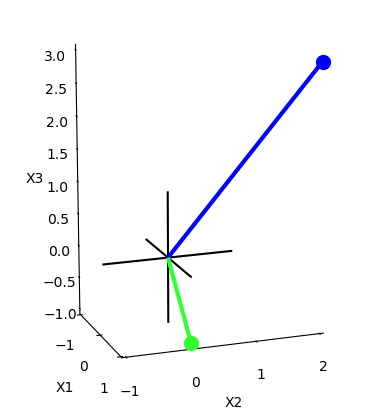

In [3]:
x = np.array([1, 2, 3])
y = np.array([1, 0, -1])

draw_3d_axes(1, ztick_freq=0.5)
draw_vector(x, 'b')
draw_vector(y, [.2, 1, .2])

In [4]:
# define a function that calculates cosine similarity
def cos_sim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


# or, alternatively:
from scipy.spatial.distance import cosine
def cos_sim_alt(x, y):
    return 1 - cosine(x, y)


# calculate the cosine sim
cossim_xy = cos_sim(x, y)

# (also calculate it with the alternative function to show they're the same)
cossim_xy_alt = cos_sim_alt(x, y)

print(f"{cossim_xy = }")
print(f"{cossim_xy_alt = }")

cossim_xy = -0.3779644730092272
cossim_xy_alt = -0.3779644730092273


In [5]:
# calculate theta, the angle (in radians)
theta_hat = np.arccos(cossim_xy)
print(f"{theta_hat = }")

# convert radians to degrees. radians = (pi/180) * degrees
theta_hat * 180 / np.pi  # in degrees

theta_hat = 1.958393013450077


112.2076542985965

**Euclidean distances** are calculated as the straight-line distances between points. By the Pythagorean Theorem, $c^2 = a^2 + b^2$, so $c = \sqrt{a^2 + b^2}$. Here, $\mathbf{a}$ and $\mathbf{b}$ are dimensions, defined by elements of $\mathbf{x}$ and $\mathbf{y}$. So the dot product $\left[ x - y\right]^T \left[x - y \right]$ is a measure of the squared geometric distance between $\mathbf{x}$ and $\mathbf{y}$. The Euclidean distance is the root mean square.

In [6]:
def eucliddist(x, y):
    return ((x - y).T @ (x - y)) ** 0.5


# is the same as
def eucliddist2(x, y):
    return np.sqrt(np.dot(x - y, x - y))
    
# and also the same as
def eucliddist3(x, y):
    return np.sqrt(np.sum((x - y) ** 2))


# or, more simply
def eucliddist4(x, y):
    return np.linalg.norm(x - y)


print(f"{eucliddist(x, y) = }")
print(f"{eucliddist2(x, y) = }")
print(f"{eucliddist3(x, y) = }")
print(f"{eucliddist4(x, y) = }")

eucliddist(x, y) = 4.47213595499958
eucliddist2(x, y) = 4.47213595499958
eucliddist3(x, y) = 4.47213595499958
eucliddist4(x, y) = 4.47213595499958


In [7]:
# SciPy is a free and open-source Python library used for scientific and 
# technical computing. It contains modules for optimization, linear 
# algebra, integration, interpolation, special functions, FFT, signal 
# and image processing, ODE solvers, and other tasks common in science 
# and engineering. 
# Within SciPy, the scipy.spatial.distance module's "pdist" function 
# calculates pairwise distances between any set of points (vectors), 
# where rows define the points and columns the dimensions of the space.

# Note: in the equivalent MATLAB code, `d = pdist([x'; y'], 'Euclidean')`,
# `[x'; y']` vertically concatenates (stacks) the two vectors `x` and `y`.
# The `numpy.vstack()` function does the same thing in Python.
from scipy.spatial.distance import pdist

d = pdist(np.vstack((x, y)), 'euclidean') # like in MATLAB, Euclidean distance is the default metric
print(f"{d = }")

d = array([4.47213595])


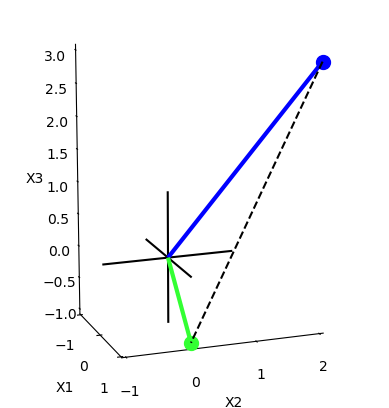

In [8]:
# Plot two vectors in 3-D space: a in blue, b in green.
# Show the distance as a dashed black line.
draw_3d_axes(1, ztick_freq=0.5)
draw_vector(x, 'b')
draw_vector(y, [.2, 1, .2])
plt.plot([x[0], y[0]], [x[1], y[1]], [x[2], y[2]], c='k', ls='--', zorder=6)
plt.show()

## Vector magnitude, norm, and sums of squares

$x^\prime x$ (or $x^T x$) is the sum of squared values.

In [9]:
x = np.array([[1, 2, 3]]).T  # or, x = np.array([[1], [2], [3]])
print(f"{x = }")
print(f"{x.shape = }")

print((x.T @ x).item())
print(f"{1**2 + 2**2 + 3**2 = }")

x = array([[1],
       [2],
       [3]])
x.shape = (3, 1)
14
1**2 + 2**2 + 3**2 = 14


In geometric terms, the square root of $x^\prime x$ (a.k.a. $x^T x$), or $\sqrt{\| x \|}$ , is the distance from zero. This is the vector's **magnitude**, also known as it's **2-norm** or  **L2-norm,** or **Euclidean norm.** A **unit vector** is a vector with a magnitude of 1, often used to represent a direction without regard to magnitude.The dot product $x^\prime x$ is a measure of the squared geometric distance from 0. The Euclidean distance from zero is its square root.

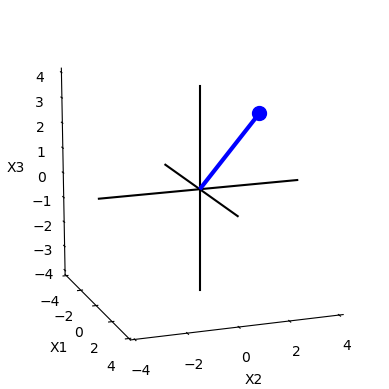

In [10]:
ax = draw_3d_axes(4, xtick_freq=2, ytick_freq=2)

draw_vector(x, 'b')

In a linear model, the 3 dimensions here can represent observations or model predictors, depending on the equation in question. If zero is a meaningful value, then $x^\prime x$ takes on particular meaning. For example, if $x$ is an $\left[m \times 1\right]$ vector of residuals from $m$ observations, $e$, from a linear model, then $e^\prime e$ is the  **sums of squared errors (SSE).** So the SSE is (1) the norm of the error vector and (2) the distance of the error vector from 0 in a space defined my $m$ independent observations. The **mean squared error** (MSE) is the average squared error per observation (element of $e$), or $\frac{x^\prime x}{m}$

## Covariance and correlation

Often, the mean of a vector is uninteresting, and we want to understand how observations vary around the mean. This is generally true in statistics, where we are usually interested in analyzing variation among observations. **Variance** is a measure of deviations around a sample mean. It is defined as the mean squared deviation from the sample mean, divided by the **degrees of freedom** (df). The **df** is the number of independent dimensions along which scores can vary. Here this is the number of independent observations - 1 (as we have estimated the mean). Here we use $m - 1$ instead of $m$ to account for the loss of a degree of freedom when estimating the sample mean:

$$
\mathrm{var}(x) = \frac{(x - \bar{x} )^T (x - \bar{x})}{m - 1} = \frac{\| x \|^2}{m - 1}
$$ 

The standard deviation is the square root of variance. If $e$ is a vector of errors from a model:

$$
\mathrm{var}(e) = \sigma^2, \quad \mathrm{std}(e) = \sigma
$$

Covariance is a measure of similarity of shared deviations from a mean. The covariance of two $m$-length vectors $x$ and $y$ is:

$$
\mathrm{cov}(x, y) = \frac{(x - \bar{x})^T (y - \bar{y})}{m - 1}
$$

Covariance is often defined in terms of the expected values of **random variables,** which do not have discrete values but instead are:

$$
\begin{align*}
  \mathrm{Cov}(X, Y) &= E\left[(X - E \left[ X \right])(Y - E\left[ Y \right])\right] \\
  \mathrm{Cov}(X, Y) &= E\left[XY\right]-E\left[X\right]E\left[Y\right]
\end{align*}
$$

In [11]:
# Generate instances of two normally distributed random variables a and b,
# with m = 10 observations each.
np.random.seed(0)    # Seed the random state for consistent output
a = np.random.rand(10)
b = np.random.rand(10)

cv = np.cov(a, b)
print(f"{cv = }")


cv2 = (a - a.mean()).T @ (b - b.mean()) / (len(a) - 1)
print(f"{cv2 = }")

# Note: `cv` is the covariance *matrix*; `cv2` is specifically the 
# covariance between `a` & `b`, which is the upper right & lower left 
# elements of the matrix

cv = array([[0.03781221, 0.02337308],
       [0.02337308, 0.12876287]])
cv2 = 0.023373083984198725


Like the dot product, the units of covariance depend on the **scale** of the variables. For example, we can measure reaction times in seconds or minutes, and changing the units affects the scale of the  response (and thus the mean, variance, and covariance), but not the similarity in reaction times across two tasks. **Correlation** additionally scales each variable by its variance. For a $z$-scored variable standardized to mean 0 and standard deviation 1:

$$
z_x = \frac{x - \bar{x}}{\mathrm{std}(x)}, \quad z_y = \frac{y - \bar{y}}{\mathrm{std}(y)}
$$

Pearson's correlation ($r$) is the covariance of the standardized variables:

In [12]:
from scipy.stats import zscore, pearsonr

# Note: calling `scipy.stats.zscore` with `ddof=0` (the default) computes
# the z-score based on the *population* standard deviation. Passing 
# `ddof=1` computes it based on the sample standard deviation, which is 
# the default behavior of MATLAB's `zscore` function 
print(np.cov(zscore(a, ddof=1), zscore(b, ddof=1)), '\n')

# or equivalently:
print(np.corrcoef(a, b), '\n')

# or, more conveniently for only two sets of observations:
print(pearsonr(a, b), '\n')

# and finally, as shown in the MATLAB version:
r = cv[0, 1] / np.prod(np.diag(cv) ** 0.5)
print(f"{r = }")

[[1.         0.33496905]
 [0.33496905 1.        ]] 

[[1.         0.33496905]
 [0.33496905 1.        ]] 

PearsonRResult(statistic=0.3349690490522055, pvalue=0.3440851015397072) 

r = 0.3349690490522054


## Orthogonality, correlation, and independence

Orthogonality refers to the concept of two vectors being perpendicular to each other in a given vector space. Mathematically, two vectors $\mathbf{a}$ and $\mathbf{b}$ are orthogonal if and only if their dot product is zero. This means that they are at *right angles* to one another. 

Below, we'll plot two vectors in 3-D space: $\mathbf{a}$ in blue, $\mathbf{b}$ in green.

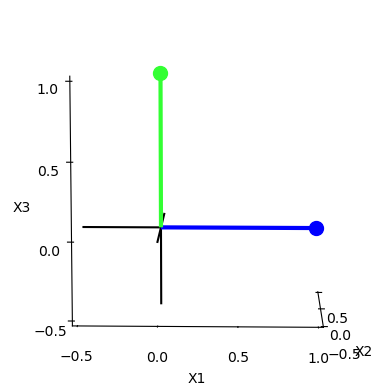

In [13]:
a = np.array([1, 0, 0])
b = np.array([0, 0, 1])

ax = draw_3d_axes(0.5)
draw_vector(a, 'b')
draw_vector(b, [.2, 1, .2])
ax.view_init(9.29, -88.59)

Does this mean that they are uncorrelated?

Does it mean that they are linearly independent?

These are different concepts:
- $X$ and $Y$ are linearly independent iff there is no constant  $a$ such that $aX -  Y = 0$. Unless vectors are perfectly aligned so that $\vert\mathrm{cos}(\theta)\vert=1$, vectors are linearly independent. 
- $X$ and $Y$ are orthogonal iff $X^\prime Y = 0$.  All orthogonal vectors are independent, so orthogonality is a special case of independence.
- $X$ and $Y$ are uncorrelated iff $(X - \bar{X})^\prime(Y - \bar{Y}) = 0$. Vectors can be orthogonal but not uncorrelated. If both varables are mean-zero and uncorrelated, they must be orthogonal. But if they are not mean-zero, they may be uncorrelated but nonorthogonal. 

Consider the vectors $\vec{a}$ and $\vec{b}$ above.

In [14]:
# Consider orthogonality
dotproduct = np.dot(a, b)
print(f"{dotproduct = }")

# Consider the correlation
r = pearsonr(a, b)[0]    # `pearsonr` returns r- & p-values; `[0]` gets just r
print(f"{r = }")

dotproduct = 0
r = -0.5000000000000001


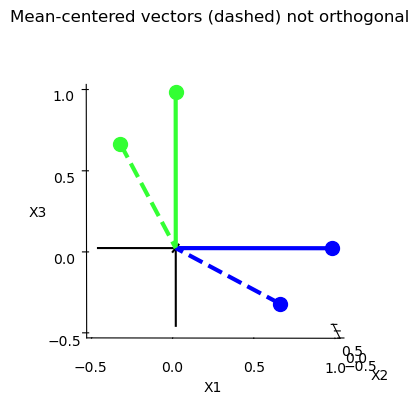

In [15]:
ax = draw_3d_axes(0.5)
draw_vector(a, 'b')
draw_vector(b, [.2, 1, .2])
draw_vector(a - a.mean(), 'b', linestyle='--')
draw_vector(b - b.mean(), [.2, 1, .2], linestyle='--')
ax.view_init(1.51, -89)
ax.set_title('Mean-centered vectors (dashed) not orthogonal')
plt.show()

Here is a useful Venn diagram of the relationships from this paper:

![](https://d3i71xaburhd42.cloudfront.net/177dc3b719fdb7b2c01d6c341e0bd58a09a47a83/2-Figure1-1.png)

## Projection

The projection of vector $\vec{a}$ onto vector $\vec{b}$ is the length of vector $\vec{a}$ along the direction defined by vector $\vec{b}$. We can think of it like the "shadow" of $\vec{a}$ in the direction defined by $\vec{b}$. [This link](https://www.cuemath.com/algebra/dot-product/) or [this one](https://en.wikipedia.org/wiki/Dot_product) has more.

$$
proj_b(a) = \mathrm{cos}(\theta_{ab})~\mathrm{norm}(a) = \frac{a \cdot b}{\| b \|}
$$

This gives the scalar projection, a magnitude, to be multiplied by the unit vector in the direction of $\vec{b}$, $\frac{b}{\| b \|}$ 

In statistical modeling, $\vec{b}$ will be a predictor (or a set of them defining a model subspace), and $\vec{a}$ will be a data vector that we are projecting onto the model subspace.

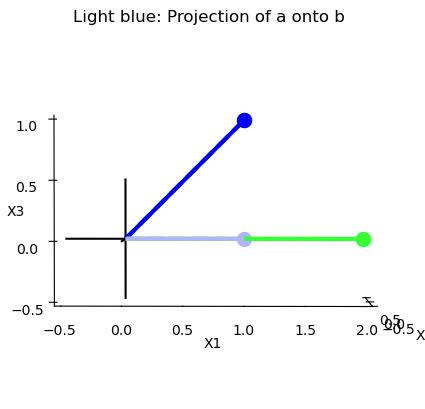

In [16]:
a = np.array([1, 0, 1])
b = np.array([2, 0, 0])

a_onto_b = (np.dot(a, b) / np.linalg.norm(b)) * (b / np.linalg.norm(b))

ax = draw_3d_axes(0.5)
draw_vector(a, 'b')
draw_vector(b, [.2, 1, .2])

# note: these two lines are redundant with the two above, but they exist 
# in the MATLAB version so they're also included here
draw_vector(a, 'b', linestyle='--')
draw_vector(b, [.2, 1, .2], linestyle='--')

draw_vector(a_onto_b, [.7, .7, 1])
ax.view_init(1.51, -89)
ax.set_title('Light blue: Projection of a onto b')
ax.set_zlabel(ax.get_zlabel(), labelpad=-5)
plt.show()

# Extension to matrices

## Linear combinations

A linear combination is  an expression constructed from a set of terms (variables) by multiplying each term by a scalar (positive or negative) and adding the results. In the context of matrices, it involves multiplying vectors by scalars and adding or subtracting the resulting products.

$$
w = a_1 v_1 + a_2 v_2 + \ldots + a_n v_n
$$

The coefficients $\left[a_1~a_2~a_3\right]$ define the linear combination.

The set of all possible linear combinations of $p$ independent variables includes all points within a $p$-dimensional **subspace**. In 2-D, this would be a plane, or in 3-D a volume.

$$
\begin{align*}
  v_1 &= \left[1, 2\right]^T \\
  v_2 &= \left[3, 4\right]^T \\
  w &= 2v_1 - 3v_2 = 2\left[1, 2\right]^T - 3\left[3, 4\right]^T = \left[-7, -10\right]^T
\end{align*}
$$

## Matrix variance/covariance

If $X$ has multiple columns, $X^\prime X$ is a **square matrix** with the sum of squares on the diagonal, and dot products of its columns on the off-diagonal. This is the *normal matrix* or [Gram matrix](https://en.wikipedia.org/wiki/Gram_matrix).

In [17]:
np.random.seed(1)    # Seed the random state for consistent output
X = np.random.rand(50, 4)
np.dot(X.T, X)    # or, X.T @ X

array([[17.00671286, 13.91239596, 10.03158447, 13.48354696],
       [13.91239596, 16.98596379,  9.87812844, 13.40549406],
       [10.03158447,  9.87812844, 12.8081555 , 10.61002285],
       [13.48354696, 13.40549406, 10.61002285, 18.98150792]])

It is related to the variance/covariance matrix of the columns of $X$.  As above, if columns are mean-zero, $X^\prime X$ is the covariance matrix * df.  The df is the number of independent dimensions along which scores can vary, which is the independent observations - 1 (as we have estimated the mean). 

Thus, if $X$ columns are mean-centered, $X^\prime X = \mathrm{cov}(X) * (m - 1)$

In [18]:
print(((X - X.mean(axis=0)).T @ (X - X.mean(axis=0))) / (X.shape[0] - 1), '\n')

print(np.cov(X, rowvar=False))  # compare: same

[[ 0.09406389  0.02628998  0.00142318  0.00266454]
 [ 0.02628998  0.08430674 -0.00542458 -0.00390935]
 [ 0.00142318 -0.00542458  0.09803052 -0.00243922]
 [ 0.00266454 -0.00390935 -0.00243922  0.09386722]] 

[[ 0.09406389  0.02628998  0.00142318  0.00266454]
 [ 0.02628998  0.08430674 -0.00542458 -0.00390935]
 [ 0.00142318 -0.00542458  0.09803052 -0.00243922]
 [ 0.00266454 -0.00390935 -0.00243922  0.09386722]]


## Independence of columns

The number of independent column vectors defines the dimensionality of the space that a matrix spans. This is called the **rank** of the matrix. If $X$ is a design matrix, this is the number of independent predictors (i.e., regressors).

If the values in the rows fill all the dimensions, the matrix will be **full rank**.

In [19]:
np.linalg.matrix_rank(X)

4

Only if a matrix is **full-rank** is its normal matrix invertible. This inversion is critical to solving the normal equation and estimating regression coefficients $\hat{\beta}$. If the matrix is not full rank, there will be no unique solution for $\hat{\beta}$, but rather an infinite family of solutions. An intuition for this is that two perfectly redundant predictors should each explain the data ($y$) equally well, so it's unclear which should be assigned a higher $\hat{\beta}$.

In [20]:
np.linalg.inv(X.T @ X)

array([[ 0.21426526, -0.11286282, -0.03858485, -0.05092786],
       [-0.11286282,  0.208894  , -0.03149835, -0.04975041],
       [-0.03858485, -0.03149835,  0.17032031, -0.04554911],
       [-0.05092786, -0.04975041, -0.04554911,  0.14945568]])

Consider $Y$, which is a copy of $X$ with an additional column. The additional column is a perfect **linear combination** of the other columns, so it "lives within" the existing 4-dimensional space and does not add a new dimension. 

In [21]:
Y = np.hstack((X, np.dot(X, [.5, .5, -.4, 0])[..., np.newaxis]))
# The new column of Y is a linear combination of other variables
print(f"rank of Y: {np.linalg.matrix_rank(Y)}")

# NOTE: this function doesn't warn about rank deficient matriceas like 
# MATLAB's version does, but the results will be inaccurate. 
# `numpy.linalg.matrix_rank()` should be checked instead.
np.linalg.inv(Y.T @ Y)

rank of Y: 4


array([[ 3.74526007e+13,  3.74526007e+13, -2.99620805e+13,
        -2.27546536e-02, -7.49052013e+13],
       [ 3.74526007e+13,  3.74526007e+13, -2.99620805e+13,
        -2.15772081e-02, -7.49052013e+13],
       [-2.99620805e+13, -2.99620805e+13,  2.39696644e+13,
        -6.80876726e-02,  5.99241611e+13],
       [-3.10415303e-02, -2.98640848e-02, -6.14581712e-02,
         1.49455677e-01, -3.97726567e-02],
       [-7.49052013e+13, -7.49052013e+13,  5.99241611e+13,
        -5.63464102e-02,  1.49810403e+14]])

## Basis sets

In linear algebra, a basis set is a set of vectors that span a vector space $V$. This defines a coordinate system for vectors in the space. A basis set consists of $p$ vectors that satisfies two main properties:

1.  The vectors are linearly independent, meaning that no vector is a linear combination of the others.
2. The vectors span the space $V$, meaning that there is a linear combination of the basis vectors that can reach any point in the space $V$.

For example,  

$$
e_1 = \begin{bmatrix}
  1 \\
  0 \\
  0 \\
\end{bmatrix},
\quad
e_2 = \begin{bmatrix}
  0 \\
  1 \\
  0 \\
\end{bmatrix},
\quad
e_3 = \begin{bmatrix}
  0 \\
  0 \\
  1 \\
\end{bmatrix}
$$ 

is the standard basis for ${\mathbb{R}}^3$, 3-D geometric space. These can be collected into a matrix:

$$
E = \begin{pmatrix} 
  1 & 0 & 0 \\
  0 & 1 & 0 \\
  0 & 0 & 1 \\
\end{pmatrix}
$$

If the basis vectors are orthogonal and have a norm = 1, this is an **orthonormal** basis set, and the matrix $E$ is an  **orthogonal matrix.** Here, $E$ is the **identity matrix**, the simplest kind of orthogonal matrix.

In the GLM, columns of the design matrix ($X$) are vectors that provide a basis set. These are usually not orthogonal, though they can be if the design matrix reflects an experimental design with orthogonal factors. The data vector is projected onto the basis set using an optimal linear combination $\hat{\beta}$ to produce fitted values.

## Rotations

Rotation matrices are [square matrices](https://en.wikipedia.org/wiki/Square_matrix), with [real](https://en.wikipedia.org/wiki/Real_number) entries. More specifically, they can be characterized as [orthogonal matrices](https://en.wikipedia.org/wiki/Orthogonal_matrix) with [determinant](https://en.wikipedia.org/wiki/Determinant) 1. (The determinant can be thought of as related to the volume described by the columns of a matrix. The determinant of the identity matrix is 1). The columns of $R$ form a basis set for the space in which the rotation occurs. Orthogonal matrices representing rotations (as opposed to reflections) have a determinant of +1. If the determinant is -1, it represents a reflection. A few properties of rotation matrices include:
- They are square matrices.
- They are orthogonal matrices, meaning their rows and columns are orthonormal unit vectors. Consequently, the inverse of a rotation matrix is simply its transpose ($R^{-1} = R^T$). 
- Their determinant is 1 (or -1 if they include reflection). 

$$
R = \begin{pmatrix}
  \mathrm{cos}(\theta) & -\mathrm{sin}(\theta) & 0 \\
  \mathrm{sin}(\theta) & \mathrm{cos}(\theta) & 0 \\
  0 & 0 & 1
\end{pmatrix}
$$

If the 3 dimensions of  $R$ are $x$, $y$, and $z$ spatial dimensions, respectively, this matrix represents a counterclockwise rotation of $\theta$ radians around the $z$-axis. The matrix can be extended for other axes and more dimensions. Zeros on the off-diagonals 

An **orthogonal rotation** is a linear transformation that preserves the lengths of vectors and the angles between them. The transformation is carried out through multiplication by an **orthogonal matrix**.

## Projections

A [**projection matrix**](https://en.wikipedia.org/wiki/Projection_matrix) is a square matrix that implements a projection onto a subspace spanned by the columns of $P$.  This generalizes the idea of a projection onto a 1-D line above. Unlike rotation matrices, projection matrices can rescale the data to which they are applied. Projection matrices: 
- Do not necessarily preserve the length of vectors. 
- Are idempotent, which means applying the matrix multiple times has the same effect as applying it once: $P^2 = P$.
- Their determinant can be 0, in the case where they project onto a subspace of lower dimensionality than the original space. 

A symmetric projection matrix is an **orthogonal projection matrix ($P$),** sometimes also called the **influence matrix** or **hat matrix ($H$).** This is also the matrix that produces the model fits in the GLM when applied to data.

An **orthogonal projection matrix** is a special kind of projection matrix used to project vectors orthogonally onto a subspace. In this context, "orthogonally" means that the vectors are projected onto the closest point in the subspace, resulting in the residual vector being perpendicular to the subspace.

An orthogonal projection matrix $P$ satisfies two main properties:
1. It is symmetric: $P = P^T$
2. It is idempotent, which means applying the matrix multiple times has the same effect as applying it once: $P^2 = P$

The formula for constructing an **orthogonal projection matrix** onto the column space of a given matrix $X$ (with linearly independent columns) is:

$$
P = X(X^\prime X)^{-1} X^\prime
$$

We can think of this as being broken down into the outer product $XX^\prime$, and the inner product $(X^\prime X)^{-1}$ . If $X$ were an orthonormal basis set, $(X^\prime X)^{-1}$ would be the identity matrix, and it would not change the product relationship.

In [22]:
# Consider orthogonal predictors
X = np.array([[1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1]]).T
print(f'{X = }\n')

# generate an arbitrary data vector
y = np.array([3, 6, 4, 2, 5, 1])
print(f'{y = }\n')

print('Normal matrix')
print(X.T @ X, '\n')  # normal matrix. off diag are 0 because ortho.

print('Inverse normal matrix')
print(np.linalg.inv(X.T @ X), '\n')

print('Projection matrix')
H = X @ np.linalg.inv(X.T @ X) @ X.T  # Hat matrix, projection matrix
print(H, '\n')

print('Three ways of calculating the scalar projections for each column')
# Note: there are only two here, but the same is true in the MATLAB version
print(f'{np.linalg.pinv(X) @ y = }')
print(f'{np.linalg.inv((X.T @ X)) @ X.T @ y = }\n')

print('Because predictors are orthogonal, we can apply the 1-D projection separately and get the same thing:')
y_onto_x1 = y @ X[:, 0] / np.linalg.norm(X[:, 0]) ** 2
print(f'{y_onto_x1 = }')
y_onto_x2 = y @ X[:, 1] / np.linalg.norm(X[:, 1]) ** 2
print(f'{y_onto_x2 = }')
y_onto_x = y @ X / np.linalg.norm(X, axis=0) ** 2
print(f'{y_onto_x = }\n')

print('This is the same as the vector of sample means:')
print(f'{[y[X[:, 0] == 1].mean(), y[X[:, 1] == 1].mean()] = }\n')

print('The resulting projection:')
y_hat = H @ y
print(f'{y_hat = }')

X = array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1]])

y = array([3, 6, 4, 2, 5, 1])

Normal matrix
[[3 0]
 [0 3]] 

Inverse normal matrix
[[0.33333333 0.        ]
 [0.         0.33333333]] 

Projection matrix
[[0.33333333 0.33333333 0.33333333 0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         0.33333333 0.33333333 0.33333333]] 

Three ways of calculating the scalar projections for each column
np.linalg.pinv(X) @ y = array([4.33333333, 2.66666667])
np.linalg.inv((X.T @ X)) @ X.T @ y = array([4.33333333, 2.66666667])

Because predictors are orthogonal, we can apply the 1-D projection separately and get the same thing:
y_onto_x1 = 4.333333333333334
y_onto_x2

Questions:
-  What is the dimensionality of the space spanned by $X$?
-  Is $X$ an orthonormal basis set?  Why/why not?
-  How would you test the idempotency property?

If $X$ is not orthonormal, $(X^\prime X)^{-1}$ includes several "normalizing" elements:

-  It includes a normalizing factor that is related to $\frac{1}{\mathrm{norm}(X)}$ (and is exactly this for orthogonal matrices).
-  It rotates the axes of the space into an orthogonal space defined by the columns of $X$, so that the betas reflect the unique projection onto the corresponding column of $X$.

By using the inverse, we are rotating the space, in this case to an orthonormal basis that spans the model subspace defined by $X$.

## Multivariate distance (Mahalanobis)

There is a close relationship between multivariate distance and the solution to beta-hat. We can think of this as rotating the axes of the space  to the axes defined by the covariance of X.

*MATLAB version ended here*. Note that the SciPy library provides a ready-to-use Mahalanobis distance function: 
```python
from scipy.spatial.distance import mahalanobis
```